In [5]:
import matplotlib.pyplot as plt

from distributions.sequence import Sequence

from algorithms.full_bandit_exp3 import FullBanditExp3

import numpy as np
import pandas as pd
import seaborn as sns

import pickle
import json

import os

In [6]:
def get_name(run_name):
    return run_name.split("_")[0]

def get_length(run_name):
    return run_name.split("_")[1]

def theoretical_bound(T, sequence: Sequence):
    return 8 * sequence.m * np.sqrt(T * sequence.K * sequence.d * np.log(np.e * sequence.K / sequence.m) * np.log(np.sqrt(T) * sequence.m * sequence.sigma * sequence.R))



In [7]:
sample_sequences = {}
results = {}
distributions = os.listdir(f"output/")
for dist_index, dist in enumerate(distributions):
    results[dist] = {}
    sample_sequences[dist] = {}

    lengths = os.listdir(f"output/{dist}")

    for length_index, length in enumerate(lengths):
        results[dist][length] = {}
        
        with open(f"output/{dist}/{length}/0/sequence.json", "rb") as input_file:
            sample_sequences[dist][length] = pickle.load(input_file)

        algo_names = os.listdir(f"output/{dist}/{length}/0")
        algo_names = np.unique([x.split("_")[0] for x in algo_names])
        algo_names = algo_names[algo_names != "sequence.json"]
        print(algo_names)

        for algo_name in algo_names:
            results[dist][length][algo_name] = {
                "regret": [],
                "gamma": [],
                "time_elapsed": [],
            }

            iterations = os.listdir(f"output/{dist}/{length}/")
            for iteration in iterations:
                with open(f"output/{dist}/{length}/{iteration}/{algo_name}_general_info.json", "r") as input_file:
                    input_dict = json.load(input_file)

                result_buffer = results[dist][length][algo_name]
                result_buffer["regret"].append(input_dict["regret"])
                result_buffer["gamma"].append(input_dict["gamma"])
                result_buffer["time_elapsed"].append(input_dict["time_elapsed"])

for dist_name in results.keys():
    for length in results[dist_name].keys():
        for algo_name in results[dist_name][length].keys():
            for key in results[dist_name][length][algo_name].keys():
                results[dist_name][length][algo_name][key] = np.array(results[dist_name][length][algo_name][key])

['FullBanditExp3Inv' 'NonContextualExp3' 'OnePerContext' 'RealLinExp3'
 'SemiBanditFTRLInv' 'UniformRandom']


In [8]:
for dist in results.keys():
    for length in results[dist].keys():
        algo = FullBanditExp3()
        sequence = sample_sequences[dist][length]
        algo.set_constants(np.random.default_rng(), sample_sequences[dist][length])
        print("\n")
        print(length, "d:", sequence.d, "K:", sequence.actionset.K, "m:", sequence.actionset.m)
        #print(f"{sequence.K}/{algo.beta}*{algo.gamma}*{sequence.lambda_min}")
        print("gamma", results[dist][length]["FullBanditExp3Inv"]["gamma"][0], "M", algo.M)
        for algo_name in results[dist][length].keys():
            single_result = results[dist][length][algo_name]
            print(algo_name, "regret:", np.average(single_result["regret"]), np.std(single_result["regret"]), np.average(single_result["time_elapsed"]))




10000 d: 4 K: 3 m: 1
gamma 0.12927223909670518 M 1177
FullBanditExp3Inv regret: 286.86 129.9893857205272 188.33084427833558
NonContextualExp3 regret: 286.4 75.56983525190458 81.80456435203553
OnePerContext regret: 261.3 62.05102738875481 92.10967280864716
RealLinExp3 regret: 277.76 66.14606866624803 112.37574981689453
SemiBanditFTRLInv regret: 271.5 60.567400472531425 143.89261372566224
UniformRandom regret: 324.06 69.26540550664524 3.4494634008407594


OSError: output/BinaryContext1;3_IndependentBernoulli5;3/10000/0/FullBanditExp3Inv_probability_array.csv not found.

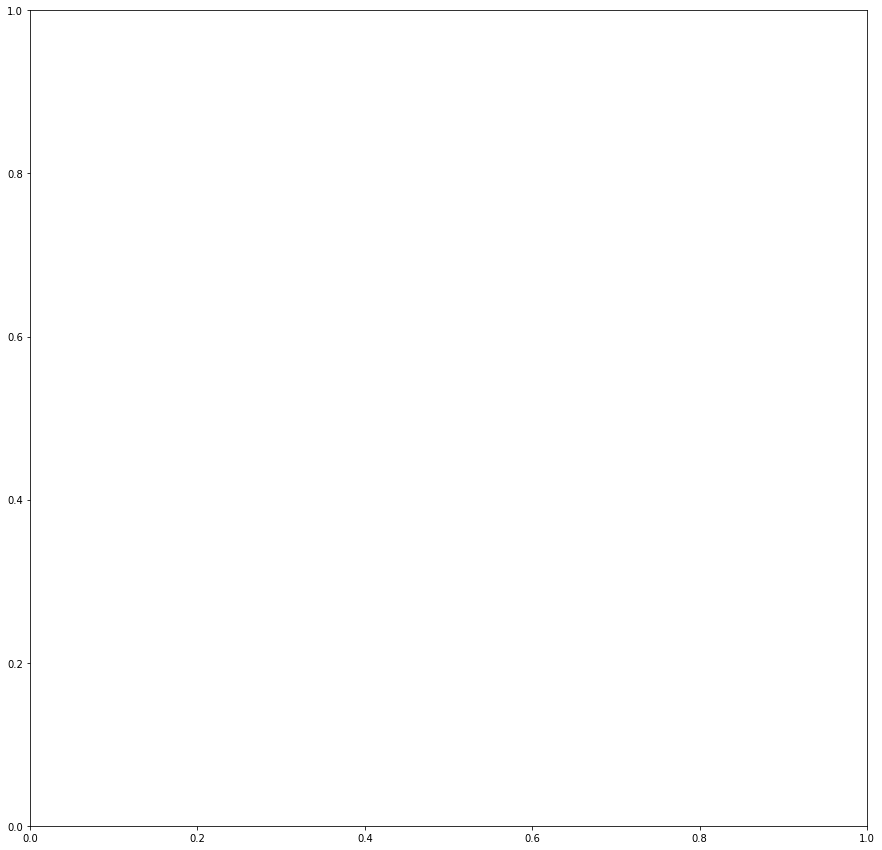

In [9]:
fig, axs = plt.subplots(figsize=(15, 15))

for algo in algo_names:
    data = np.loadtxt(f"output/BinaryContext1;3_IndependentBernoulli5;3/10000/0/{algo}_probability_array.csv")[:, 0]
    axs.plot(data, label=algo)

fig.legend()
fig.show()

In [ ]:
for name in ["FullBanditExp3"]:
    for length in results[name].keys():
        single_result = results[name][length]
        sequence = single_result["sequences"][0]

        theo = theoretical_bound(int(length), sequence)
        print(name, length, "regret:", np.average(single_result["regret"]), f"({theo:.2f})")

        data = single_result["probability_array"][:, :, 0]

        data1 = data[:, sequence.contexts[:-1, 0].astype(bool)]
        data2 = data[:, ~sequence.contexts[:-1, 0].astype(bool)]

        dataframe = pd.DataFrame(data1).melt()
        sns.lineplot(data=dataframe, x="variable", y="value", label="context 1")
        dataframe = pd.DataFrame(data2).melt()
        sns.lineplot(data=dataframe, x="variable", y="value", label="context 2")

